In [1]:
!pip install diffusers transformers

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, DDIMScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [3]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = "scaled_linear", num_train_timesteps = 1000)
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [4]:
def pil_to_latent(image):
  with torch.no_grad():
    latent = vae.encode(tfms.ToTensor()(image).unsqueeze(0).to(torch_device) * 2 - 1) #scale from -1 to 1
    latent = latent.latent_dist.sample() #picks val from latent distribution
  return latent * .18215


def latent_to_pil(latent):
  latent /= .18215
  with torch.no_grad():
    image = vae.decode(latent).sample
  image = (image/2 + 0.5 ).clamp(0,1)
  image = image.detach().cpu().permute(0,2,3,1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [5]:
token_embedding_layer = text_encoder.text_model.embeddings.token_embedding #actual tokens in the prompt. there also exists .position_embedding.

In [6]:
import torch
import torch.nn as nn

def get_output_embeds(input_embeddings):
  batch_size, seq_len = input_embeddings.shape[:2]
  # Use standard PyTorch function to build causal attention mask
  causal_attention_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, dtype=input_embeddings.dtype)
  causal_attention_mask = causal_attention_mask.to(torch_device) # Move mask to the correct device

  encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=input_embeddings,
            attention_mask=None, # We are providing causal_attention_mask instead
            causal_attention_mask=causal_attention_mask,
            output_attentions=None,
            output_hidden_states=True, #want output embdeddings not final output.
            #return_dict = None,
        )
  output = encoder_outputs[0] #only want hidden state

  output = text_encoder.text_model.final_layer_norm(output)

  return output # now we can put this through the UNet!

In [7]:
position_ids = text_encoder.text_model.embeddings.position_ids[:,:77]
position_embedding_layer = text_encoder.text_model.embeddings.position_embedding
position_embeddings = position_embedding_layer(position_ids)

In [8]:
def get_modified_output_embeddings(proompt):
  prompt = proompt

  # Tokenize
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  input_ids = text_input.input_ids.to(torch_device)

  # Get token embeddings
  token_embeddings = token_embedding_layer(input_ids)

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  print(modified_output_embeddings.shape)
  return modified_output_embeddings # now the unet can use the prompt.

In [9]:
def generate_with_embs(text_embeddings,text_input):
  height = 512
  width = 512
  num_inference_steps = 30
  generator = torch.manual_seed(32)
  guidance_scale = 7.5
  batch_size = 1

  max_length = text_input.input_ids.shape[-1] #77
  uncond_input = tokenizer([""]*batch_size, padding = "max_length", max_length= max_length, return_tensors = "pt")
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  #scheduler:
  scheduler.set_timesteps(num_inference_steps) # Correctly set timesteps

  #latents
  latents = torch.randn(
      (batch_size, unet.config.in_channels, height//8, width//8),
      generator = generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  #loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
    latent_model_input = torch.cat([latents]* 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input,t)

    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample

  return latent_to_pil(latents)[0]

In [10]:
def generate_image(prompt):
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  embs = get_modified_output_embeddings(prompt)
  return generate_with_embs(embs,text_input)

In [11]:
def get_uncond_embeddings(max_length = 77):
  batch_size = 1
  max_length = max_length #77
  uncond_input = tokenizer([""]*batch_size, padding = "max_length", max_length= max_length, return_tensors = "pt")
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  return uncond_embeddings

In [12]:
def get_timesteps(num_inference_steps, strength, device = torch_device):
    time_start = min(int(num_inference_steps * (1-strength)) + 1, num_inference_steps)
    timesteps = scheduler.timesteps[time_start:]
    return timesteps, len(timesteps)

In [13]:
def generate_mask(
    input_latents,
    scheduler,
    unet,
    prompt_reference,
    prompt_target,
    num_inference_steps,
    guidance_scale=7.5, # everything below are the paper's guidelines. so should be chill.
    strength=0.5,
    latents_num=10,
    threshold=0.5,
    seed=32,
    device="cuda"
):

    # Initial scheduler setup (needed for init_noise_sigma)
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, _ = get_timesteps(num_inference_steps, strength)
    scheduler.timesteps = timesteps
    latents = input_latents * scheduler.init_noise_sigma

    #embeddings
    ref_cond_embs   = get_modified_output_embeddings(prompt_reference)
    ref_uncond_embs = get_uncond_embeddings(max_length=77)
    tgt_cond_embs   = get_modified_output_embeddings(prompt_target)
    tgt_uncond_embs = get_uncond_embeddings(max_length=77)

    diff_accum = None

    for i in range(latents_num):
        gen = torch.Generator(device=device).manual_seed(seed * (i + 1)) #its important that the seed is controlled based on the index.

        #Add noise once at the strength timestep, now [0]
        t0 = torch.tensor([timesteps[0]], device=device)
        noise = torch.randn(
            latents.shape,
            device=latents.device,
            generator=gen
        )
        noised = scheduler.add_noise(latents, noise, t0)

        #Denoise given the latnets.
        def denoise(x, cond_embs, uncond_embs):
            # Reset step_index by reinitializing timesteps
            scheduler.set_timesteps(num_inference_steps, device=device)
            lat = x
            for t in timesteps:
                lat_in = torch.cat([lat, lat], dim=0)
                lat_in = scheduler.scale_model_input(lat_in, t)
                emb = torch.cat([uncond_embs, cond_embs], dim=0)
                with torch.no_grad():
                    noise_pred = unet(lat_in, t, encoder_hidden_states=emb).sample
                u, c = noise_pred.chunk(2)
                guided = u + guidance_scale * (c - u)
                lat = scheduler.step(guided, t, lat).prev_sample
            return lat

        ref_lat = denoise(noised.clone(), ref_cond_embs, ref_uncond_embs)
        tgt_lat = denoise(noised.clone(), tgt_cond_embs, tgt_uncond_embs)

        # calculate the per pixel difference in latent space
        diff = (ref_lat - tgt_lat).abs().mean(dim=1, keepdim=True)

        # running average of diff
        if diff_accum is None:
            diff_accum = diff
        else:
            diff_accum = diff_accum * (i / (i + 1)) + diff * (1 / (i + 1))

    #Normalize & threshold
    diff_mean = diff_accum  # already averaged over latents_num
    diff_norm = (diff_mean - diff_mean.min()) / (diff_mean.max() - diff_mean.min() + 1e-8)
    mask = (diff_norm > threshold).float()  # [1,1,H,W]

    return mask


In [14]:
#same thing as noise_image
def make_noised_latent(clean_latent, r, num_steps=50, seed=32):
    scheduler.set_timesteps(num_steps, device=torch_device)

    gen   = torch.Generator(device=torch_device).manual_seed(seed)
    noise = torch.randn(clean_latent.shape,
                        dtype=clean_latent.dtype,
                        device=torch_device,
                        generator=gen)

    # 1-D tensor whose length == batch size
    t_r = scheduler.timesteps[r].repeat(clean_latent.shape[0]).to(torch_device)

    noised_latent = scheduler.add_noise(clean_latent, noise, t_r)
    return noised_latent, noise



In [17]:
def add_noise_same_seed(latent, noise, sched):
    """
    Returns a dict {idx: latent_noised_at_t_idx} using *one* noise tensor.
    """
    B = latent.shape[0]
    return {
        i: sched.add_noise(latent, noise, t.repeat(B).to(latent.device))
        for i, t in enumerate(sched.timesteps)
    }


In [18]:
def generate_diff_edit_with_embs(
        mask,                          # [1,1,64,64] latent–resolution mask
        text_embeddings,               # encoder hidden states for the prompt
        text_input,                    # tokenizer output for the prompt
        noised_latent,                 # latent at timestep r (output of make_noised_latent)
        r,                             # index of the timestep where we *start* denoising
        latent_representation_at_timestep_t,   # dict of {i: latent_noised_at_t_i}
        num_inference_steps   = 50,
        guidance_scale        = 7.5,
        generator             = None,  # optional torch.Generator
    ):
    """
    DiffEdit denoising pass with LMSDiscreteScheduler.
    Replaces the masked region while keeping the background intact.
    """

    device      = torch_device
    batch_size  = noised_latent.shape[0]

    #prompt embeds
    max_len = text_input.input_ids.shape[-1]
    uncond  = tokenizer([""] * batch_size,
                        padding="max_length",
                        max_length=max_len,
                        return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        uncond_emb = text_encoder(uncond)[0]

    text_embeddings = torch.cat([uncond_emb, text_embeddings])

    
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps                    

    mask_lat = torch.nn.functional.interpolate(
        mask, size=noised_latent.shape[-2:], mode="nearest"
    ).to(noised_latent.dtype)

    latents = noised_latent.clone()

    #denoise to the target
    for i, t in enumerate(timesteps[r:]):              # start at index r
        # UNet forward
        latent_in = torch.cat([latents] * 2)
        latent_in = scheduler.scale_model_input(latent_in, t)

        with torch.no_grad():
            noise_pred = unet(
                latent_in, t, encoder_hidden_states=text_embeddings
            ).sample

        eps_u, eps_c = noise_pred.chunk(2)
        eps = eps_u + guidance_scale * (eps_c - eps_u)

        # denoise step
        latents = scheduler.step(eps, t, latents).prev_sample

        # keep the background. Handle going out of bounds.
        bg = latent_representation_at_timestep_t[min(i + r + 1,len(latent_representation_at_timestep_t) - 1)]

        # blend edited foreground with original background like in the paper
        latents = mask_lat * latents + (1.0 - mask_lat) * bg

    
    return latent_to_pil(latents)[0]


torch.Size([1, 77, 768])


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([1, 77, 768])
torch.Size([1, 77, 768])
torch.Size([1, 77, 768])


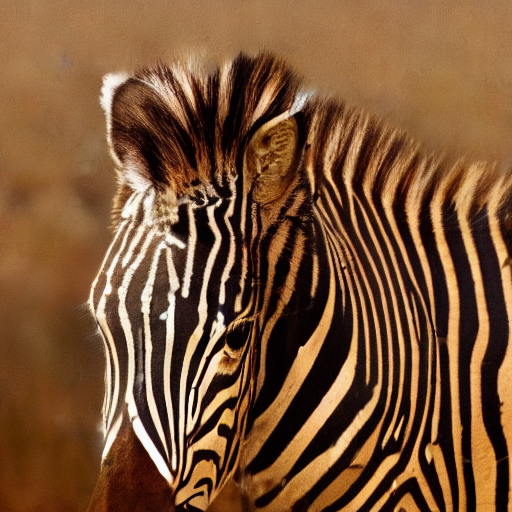

In [26]:
r                = 12
num_steps        = 100
guidance_scale   = 5 #paper recommended.
original = generate_image("horse")
base_latent = pil_to_latent(original)
noised_latent, base_noise = make_noised_latent(base_latent, r, num_steps, seed=32)
latent_representation_at_timestep_t = add_noise_same_seed(
    base_latent, base_noise, scheduler
)
bg_latents = add_noise_same_seed(base_latent, base_noise, scheduler)

mask = generate_mask(base_latent, scheduler, unet,
                     prompt_reference="horse",
                     prompt_target="zebra",
                     num_inference_steps=40,
                     latents_num=50,
                     threshold=0.08)

pos_input = tokenizer("zebra", padding="max_length",
                      max_length=tokenizer.model_max_length, return_tensors="pt")
pos_embs  = get_modified_output_embeddings("zebra")

edited = generate_diff_edit_with_embs(
    mask, pos_embs, pos_input,
    noised_latent, r,
    bg_latents,
    num_inference_steps=num_steps,
    guidance_scale=guidance_scale
)
display(edited)


In [21]:
def mask_to_pil(mask, save_path = None):
    """
    mask tensor [1,1,H,W] into a PIL.Image.
    """
    mask_np = mask.detach().cpu().numpy().squeeze()       # H×W array
    mask_img = Image.fromarray((mask_np * 255).astype('uint8'))
    if save_path:
        mask_img.save(save_path)
    return mask_img

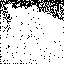

In [27]:
mask_to_pil(mask)

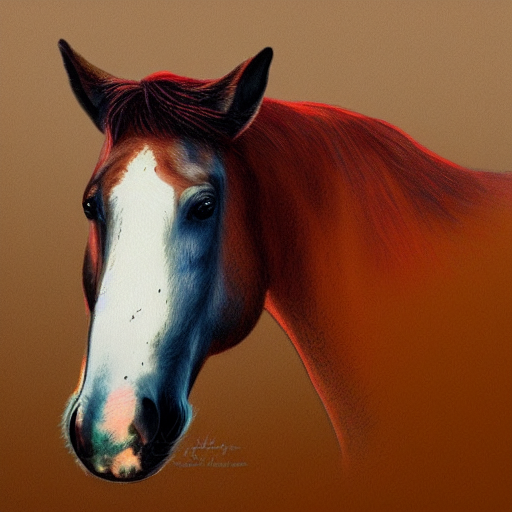

In [25]:
display(original)